# Artificial Neural Networks and Deep Learning

## I ragazzi del Bav

#### Stefano Corti, Andrea Catelli, Alessandro Ciotti, Marco Giovanni Barbero
---

## EfficientNet V2S

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
#!pip install tensorflow==2.14.0
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)
#print(tfk.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

!pip install keras-cv
import keras_cv as kcv

#!pip install tensorflow-addons
#import tensorflow_addons as tfa


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 42.9 MB/s eta 0:00:00


## 🔽 IMPORT DATA

In [ ]:
data = np.load("balanced_dataset_5000img.npz")
X_balanced = data['images']
y_balanced = data['labels']

# Split data into training + validation and test set, maintaining class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X_balanced, y_balanced, random_state=seed, test_size=0.15, stratify=y_balanced)

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.15, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)
print(type(X_train))

del data, X_balanced, y_balanced, X_train_val, y_train_val
labels = {0:"Basophil",1:"Eosinophil",2:"Erythroblast",3:"Immature granulocytes",4:"Lymphocyte",5:"Monocyte",6:"Neutrophil",7:"Platelet"}

Training Data Shape: (28900, 96, 96, 3)
Training Label Shape: (28900,)
Validation Data Shape: (5100, 96, 96, 3)
Validation Label Shape: (5100,)
Test Data Shape: (6000, 96, 96, 3)
Test Label Shape: (6000,)
<class 'numpy.ndarray'>


In [ ]:
# Normalize data to the range [0, 1]

X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding

y_test = tfk.utils.to_categorical(y_test)

In [ ]:
# Augmented train set
train = np.load("Augmented_train_randAugment_5000img.npz")
X_train = train["images"]
y_train = train["labels"]

print("Shape X train:" , X_train.shape)
print("Shape y train:" , y_train.shape)

del train

## 🏗️ NETWORK SETUP

In [ ]:
# Normalize data to the range [0, 1]
X_train = (X_train / 255).astype('float32')
X_val = (X_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
#EfficientNet V2S
EffNet = tfk.applications.EfficientNetV2S(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Display a summary of the model architecture
EffNet.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(EffNet, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
## Freeze all layers in EfficientNetB0 to use it solely as a feature extractor
EffNet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Pre processing
augmentation = tf.keras.Sequential([
    tfkl.Resizing(160, 160),
], name='preprocessing')

x = augmentation(inputs)

# Pass augmented inputs through the EfficientNet feature extractor
x = EffNet(x)

# First dense layer
x = tfkl.Dense(64, activation="relu", name="Dense1")(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense2')(x)


In [ ]:
# fine tuning model
ft_model = tfk.Model(inputs=inputs, outputs=outputs, name='model_FT')

# Enable training only for Conv2D + L2 regularization to prevent overfitting
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) :
        layer.trainable = True
        layer.kernel_regularizer = tfk.regularizers.l2(0.001)

# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-s').layers[:N]):
    layer.trainable = False

# AdamW optimizer
optimizer = tfk.optimizers.AdamW(learning_rate=0.0001)

# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

ft_model.summary(expand_nested=True)

Model: "model_FT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ resizing (Resizing)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 1280)                │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 80, 80, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 80, 80, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 80, 80, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 80, 80, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 80, 80, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 80, 80, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 80, 80, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 80, 80, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 80, 80, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 80, 80, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 80, 80, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 80, 80, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_expand_conv (Conv2D)    │ (None, 40, 40, 96)          │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,413,864 (77.87 MB)

 Trainable params: 18,352,208 (70.01 MB)

 Non-trainable params: 2,061,656 (7.86 MB)

## 💪 TRAINING - FINE TUNING

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_test*255, y_test),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
    verbose = 1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'V2S_trainV2_batch16_'+str(final_val_accuracy)+'_160x160.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/200
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 164s 52ms/step - accuracy: 0.6267 - loss: 1.0434 - val_accuracy: 0.9670 - val_loss: 0.1044
Epoch 2/200
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - accuracy: 0.8631 - loss: 0.4165 - val_accuracy: 0.9720 - val_loss: 0.0903
Epoch 3/200
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - accuracy: 0.9113 - loss: 0.2713 - val_accuracy: 0.9802 - val_loss: 0.0699
Epoch 4/200
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.9349 - loss: 0.1992 - val_accuracy: 0.9758 - val_loss: 0.0897
Epoch 5/200
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.9533 - loss: 0.1490 - val_accuracy: 0.9807 - val_loss: 0.0716
Epoch 6/200
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy: 0.9634 - loss: 0.1140 - val_accuracy: 0.9810 - val_loss: 0.1017
Epoch 7/200
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy: 0.9713 - loss: 0.0914 - val_accuracy: 0.9768 - val_loss: 0.1067
Epoch 8/200
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 50s 28ms/step - accuracy:

## 🔍 INFERENCE WITH TEST SET

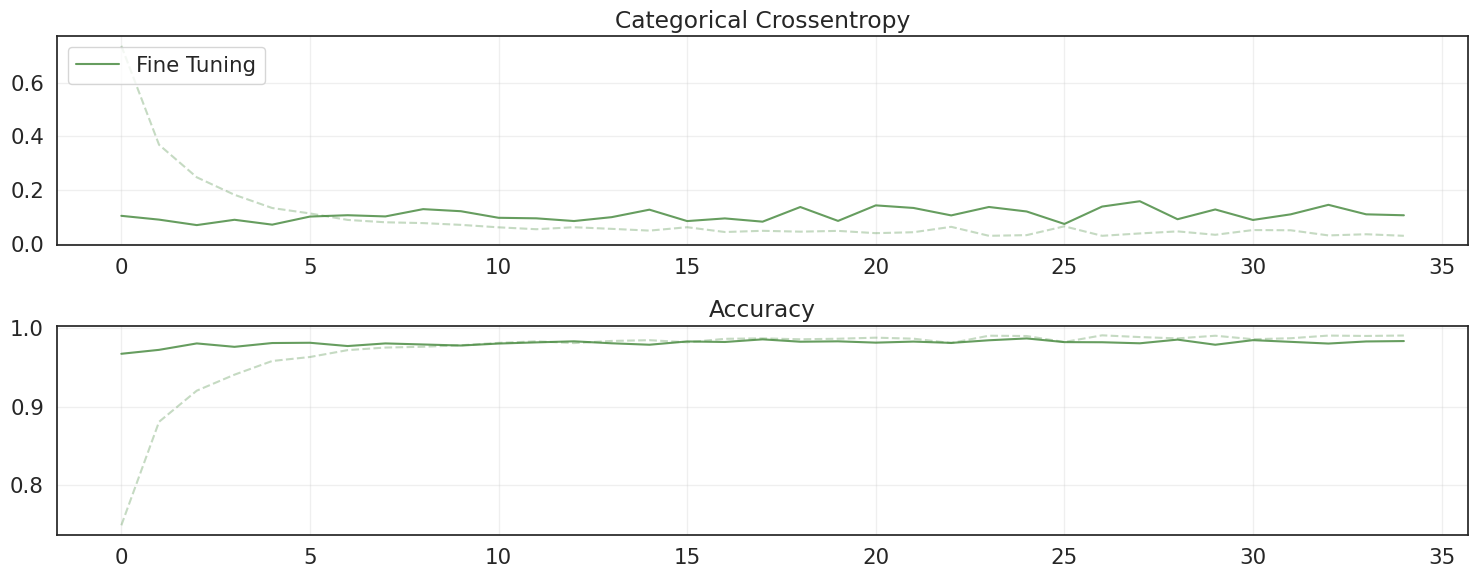

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

Predictions Shape: (6000, 8)
Accuracy score over the test set: 0.9865
Precision score over the test set: 0.9865
Recall score over the test set: 0.9865
F1 score over the test set: 0.9865


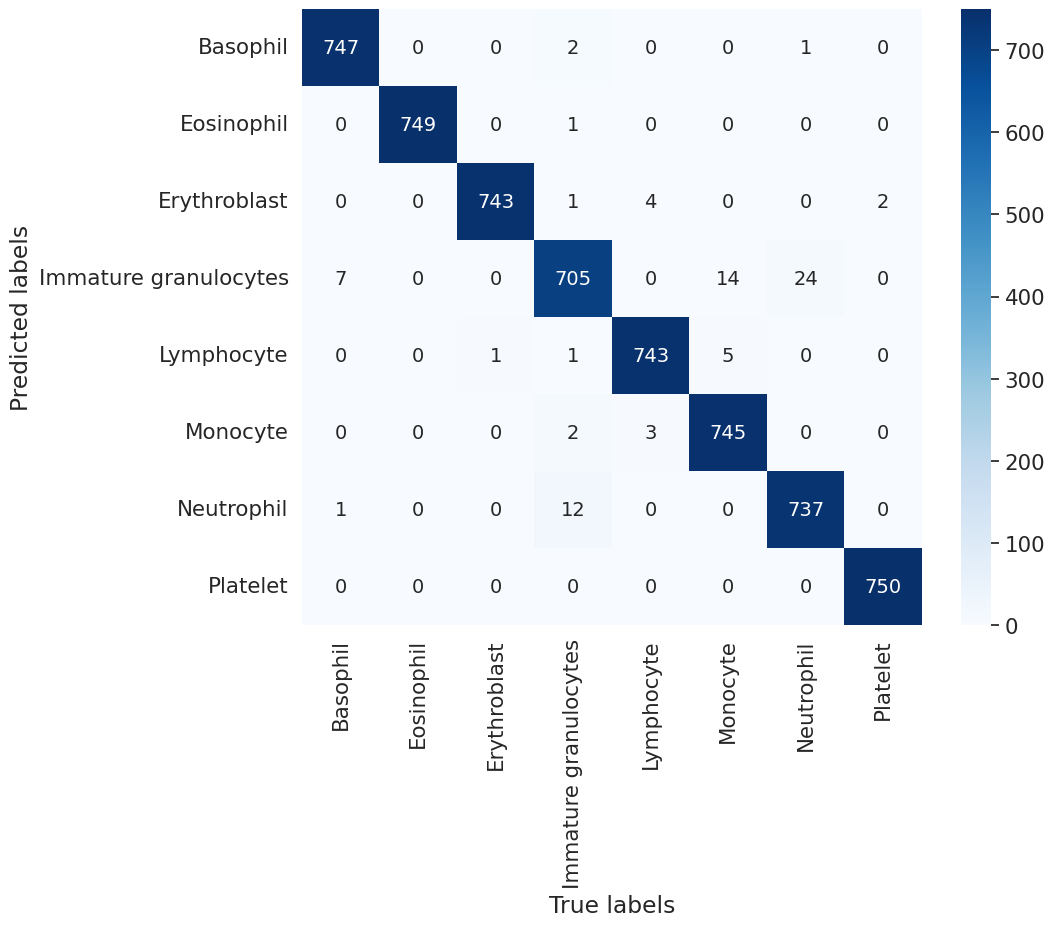

In [ ]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Predict labels for the entire test set
predictions = model.predict(X_test * 255, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class SaliencyMapGenerator:
    def __init__(self, model, image_size=(96, 96), amplification_factor=5.0):
        """
        Initialize the saliency map generator.

        Args:
            model: TensorFlow model to analyze
            image_size: Tuple of (height, width) for input images
            amplification_factor: Float to scale the saliency map for better visibility
        """
        self.model = model
        self.image_size = image_size
        self.amplification_factor = amplification_factor

    def preprocess_image(self, image):
        """
        Preprocess a single image for the model.

        Args:
            image: Input image array

        Returns:
            Preprocessed tensor ready for model input
        """
        image = tf.convert_to_tensor(image)
        image = tf.image.resize(image, self.image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return tf.expand_dims(image, axis=0)

    def compute_saliency_map(self, image, class_idx):
        """
        Compute saliency map for a given image and class index.

        Args:
            image: Input image array
            class_idx: Target class index

        Returns:
            Amplified and normalized saliency map array
        """
        processed_image = self.preprocess_image(image)

        with tf.GradientTape() as tape:
            tape.watch(processed_image)
            predictions = self.model(processed_image, training=False)
            class_score = predictions[:, class_idx]

        # Compute gradients
        grads = tape.gradient(class_score, processed_image)

        if grads is None:
            raise ValueError("Gradients could not be computed. Check model architecture and input.")

        # Take maximum across channels, normalize, and amplify
        saliency = tf.reduce_max(tf.abs(grads), axis=-1)
        saliency = saliency[0].numpy()

        # Normalize and amplify saliency map
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)
        saliency *= self.amplification_factor  # Amplify saliency for better visibility
        saliency = np.clip(saliency, 0, 1)  # Ensure values stay in [0, 1]
        return saliency

    def plot_saliency(self, image, class_idx, title=None, alpha=0.4):
        """
        Compute and plot saliency map overlaid on the original image.

        Args:
            image: Input image array
            class_idx: Target class index
            title: Optional title for the plot
            alpha: Transparency for saliency overlay
        """
        saliency = self.compute_saliency_map(image, class_idx)

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Plot original image
        ax1.imshow(np.clip(image, 0, 255).astype('uint8'))
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Plot amplified saliency map
        im = ax2.imshow(saliency, cmap='hot')
        ax2.set_title(title or f'Saliency Map (Class {class_idx})')
        ax2.axis('off')

        # Add colorbar
        plt.colorbar(im, ax=ax2)
        plt.tight_layout()
        plt.show()

def visualize_class_saliency(model, X_test, y_test, num_images_per_class=5, amplification_factor=5.0, seed=42):
    """
    Visualize saliency maps for multiple images from each class.

    Args:
        model: TensorFlow model
        X_test: Test images
        y_test: Test labels
        num_images_per_class: Number of images to visualize per class
        amplification_factor: Float to scale the saliency map for better visibility
        seed: Random seed for reproducibility
    """
    np.random.seed(seed)
    generator = SaliencyMapGenerator(model, image_size=(96,96), amplification_factor=amplification_factor)

    # Get unique classes
    unique_classes = np.unique(y_test)

    for class_idx in unique_classes:
        print(f"\nGenerating saliency maps for class {class_idx}")

        # Get indices for current class
        class_indices = np.where(y_test == class_idx)[0]

        if len(class_indices) < num_images_per_class:
            print(f"Warning: Only {len(class_indices)} images available for class {class_idx}")
            selected_indices = class_indices
        else:
            selected_indices = np.random.choice(class_indices, num_images_per_class, replace=False)

        # Generate saliency maps
        for idx in selected_indices:
            image = X_test[idx]
            pred = model.predict(generator.preprocess_image(image*255), verbose=0)
            pred_class = np.argmax(pred)

            title = f"Class {class_idx} (Predicted: {pred_class})"
            generator.plot_saliency(image, pred_class, title=title)



def visualize_incorrect_predictions_saliency(model, X_test, y_test, amplification_factor=5.0, seed=42, max_images=10):
    """
    Visualize saliency maps for images that were incorrectly classified.

    Args:
        model: TensorFlow model
        X_test: Test images
        y_test: True test labels
        amplification_factor: Float to scale the saliency map for better visibility
        seed: Random seed for reproducibility
        max_images: Maximum number of incorrect predictions to visualize
    """
    np.random.seed(seed)
    generator = SaliencyMapGenerator(model, image_size=(96,96), amplification_factor=amplification_factor)

    incorrect_indices = []
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    # Find incorrect predictions
    for idx, (true_label, predicted_label) in enumerate(zip(y_test, predicted_classes)):
        if true_label != predicted_label:
            incorrect_indices.append(idx)

    print(f"Found {len(incorrect_indices)} incorrect predictions.")

    if len(incorrect_indices) == 0:
        print("No incorrect predictions to visualize.")
        return

    # Limit the number of images visualized
    if len(incorrect_indices) > max_images:
        incorrect_indices = np.random.choice(incorrect_indices, max_images, replace=False)

    # Generate saliency maps
    for idx in incorrect_indices:
        image = X_test[idx]
        true_label = y_test[idx]
        pred_class = predicted_classes[idx]

        title = f"True: {true_label}, Predicted: {pred_class}"
        generator.plot_saliency(image, pred_class, title=title)

In [ ]:
model = tf.keras.models.load_model("V2S_trainV2_batch16_98.65_160x160.keras")
visualize_class_saliency(model, X_test*255, np.argmax(y_test,axis=-1))